In [316]:
import li
import li.analysis as la
import li.EvaluationHelpers as eh

import os
import numpy as np
import matplotlib.pyplot as plt


# Data Loading and Definition of Variables

In [367]:
# path to images
# images_set = "B-inSitu_cold_imaging_832"
# date = "20250226"

# images_set = "D-inSitu_imaging_750"
# date = "20250303"

images_set = "G-inSitu_imaging_832"
date = "20250303"

path_dir = "Z:/Archiv/2D/Experiment/2025/" + date + "/Images" + date + "/" + images_set + "/"
path_file = os.listdir(path_dir)

print(len(path_file))

1495


In [368]:
# grab loop variable names
variables = la.loop_variables(path_dir + path_file[0])[1]
var_vals = la.loop_variables(path_dir + path_file[0])[0]

In [369]:
print(variables)
print(var_vals)

['i', 'Acc_hold_time']
[array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]), array([0.041, 0.061, 0.081])]


In [370]:
# experiment variables loaded from experiment control
info = la.GetImageMetadata(path_dir + path_file[0])
info_sorted = dict(sorted(info[0].items(), key=lambda x: x[0].lower()))
# info_sorted

# Image Processing

In [371]:
%%time
# create initial dictionary with all raw images
images_raw = eh.createImageInfoList([path_dir], variables)

CPU times: total: 0 ns
Wall time: 192 ms


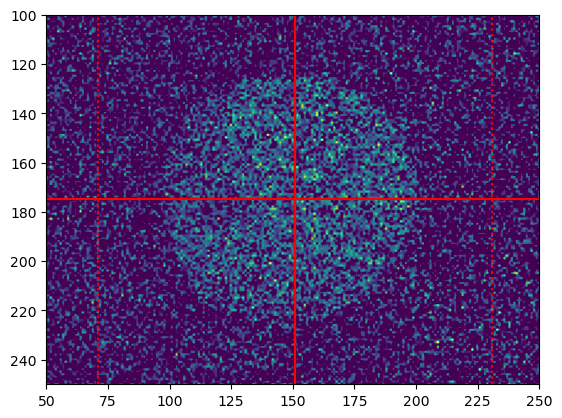

In [372]:
# determine optimal ROI
center = (175, 151)
h = 80
w = 80

single_prc = la.density_builder([images_raw[0]], variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = True)

plt.imshow(single_prc.iloc[0]["density"].data, vmin = 0, vmax = 3, cmap = "viridis")

# circle = plt.Circle((center[1], center[0]), 50, color='r', fill=False, lw = 2)
# plt.gca().add_artist(circle)

plt.xlim(50, 250)
plt.ylim(250, 100)


plt.axhline(center[0], c = "red")
plt.axhline(center[0] - h, c = "red", ls = ":")
plt.axhline(center[0] + h, c = "red", ls = ":")

plt.axvline(center[1], c = "red")
plt.axvline(center[1] - w, c = "red", ls = ":")
plt.axvline(center[1] + w, c = "red", ls = ":")


plt.show()

In [373]:
%%time
# calculate all density images and apply mask
images_prc = la.density_builder(images_raw, variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = False)

|████████████████████████████████████████| 299/299 [100%] in 1:03.0 (4.74/s)    
CPU times: total: 30.9 s
Wall time: 1min 3s


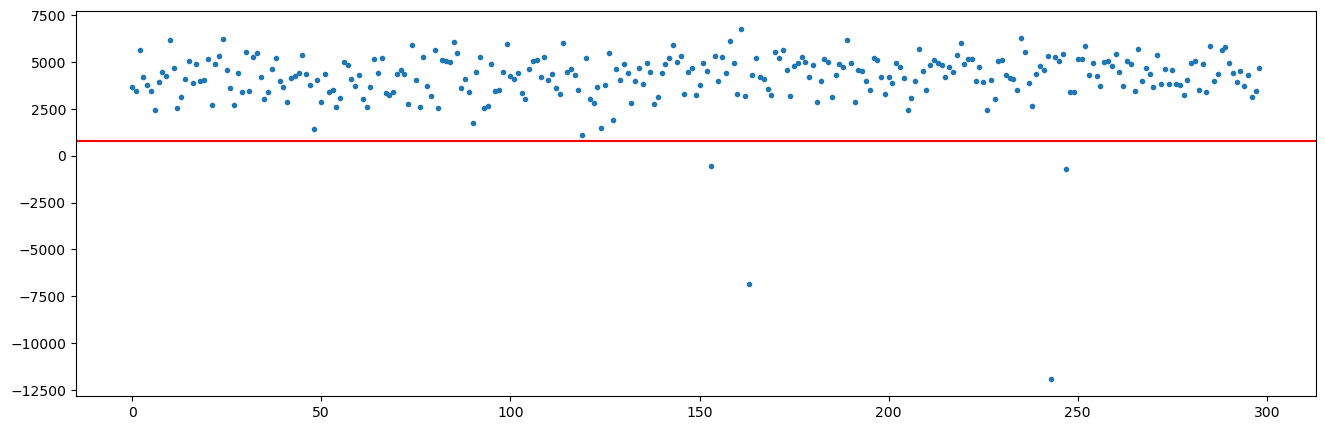

In [395]:
# filter out missed shots
bol = []

for var in var_vals[0]:

    for i, im in images_prc[images_prc["i"] == var].iterrows():
        bol.append(np.sum(im["density"]))
        # bol.append(np.sum(im["density"]))

plt.figure(figsize = (16, 5))

plt.plot(bol, ".")
plt.axhline(800, c = "r")

# plt.ylim(0, None)

plt.show()

In [376]:
%%time
# filter missed shots
images_fil = la.filter(images_prc, 800)

CPU times: total: 188 ms
Wall time: 197 ms


In [377]:
# plt.imshow(images_fil["density"][2], vmin = 0, vmax = 3, cmap = "viridis")
# plt.show()

In [378]:
from scipy import constants as const
import pandas as pd
import numpy.ma as ma

omega_T4 = 2 * const.pi * 27.3 # angular frequency of T4 harmonic [Hz]
m_Li = 9.9883414e-27           # mass of lithium [kg]
px_to_x = 1.09739368998628e-6  # effective pixel size in [m]

wl_laser = 671e-9  # resonant wavelength for imaging
sigma_factor = 1
sigma_zero = 3 * (wl_laser ** 2) / (2 * np.pi)
sigma_eff = sigma_factor * sigma_zero

A = px_to_x**2  # pixel size in m**2
gain = 1

def masked_variance(images):

    stacked_images = ma.stack(images)
    variance = ma.var(stacked_images, axis = 0)

    return variance



def group(images, keys, key_kill, Csat_rate, illumination_time):
    """
    Function:
        This function averages the densities for all combinations of loop variables with respect to the variable
        'key_kill'. The averaging is usually performed over the iterations such that 'key_kill' = 'i',
        though it can be any of the loop variables. The averaging is done by grouping the entries in the input
        dataframe by the loop variables meant to be kept and averaging over the densities in the respective groups.

    Arguments:
        images            -- {pandas dataframe} densities for all combinations of loop variables filtered for missed shots
        keys              -- {array-like} keys of all loop variables
        key_kill          -- {string} loop variable to be averaged over and "killed" from the dataframe
        Csat_rate         -- {scalar} saturation rate value for imaging
        illumination_time -- {scalar} imaging illumination time [s]

    Returns:
        {pandas dataframe} densities for all combinations of loop variables averaged over key_kill
    """

    counts_sat = Csat_rate * illumination_time * 1e6

    key_group = keys.copy()
    key_group.remove(key_kill)

    if len(keys) == 1:

        print("SINGLE MODE")

        images_grp = {}

        # averages
        images_grp["density"] = [images["density"].mean(numeric_only = False)]
        images_grp["atoms"] = [images["atoms"].mean(numeric_only=False)]
        images_grp["bright"] = [images["bright"].mean(numeric_only=False)]

        images_grp["atoms_var"] = [np.std(images["atoms"].to_numpy())**2]
        images_grp["bright_var"] = [np.std(images["bright"].to_numpy())**2]

        images_grp = pd.DataFrame(images_grp)


    else:

        print("MULTI MODE")

        # group by group keys, calculate mean of densities, reshape dataframe to grouped dataframe
        images_grp = images.groupby(key_group).mean(numeric_only = False).reset_index().drop(columns = key_kill)

        for key in list(images_grp):
            if key not in key_group:

                variance = images.groupby(key_group)[key].apply(masked_variance).reset_index().drop(columns = key_group, axis = 1)

                variance.rename(columns = {key: key + "_var"}, inplace=True)
                images_grp = pd.concat([images_grp, variance], axis = 1).reindex(images_grp.index)

    images_grp["fringe_var"] = images_grp["bright_var"] - gain * images_grp["bright"]

    images_grp["number_var"] = ((A / sigma_eff * (1 / images_grp["atoms"] + 1 / counts_sat)) ** 2 *
                                (images_grp["atoms_var"] - gain * images_grp["atoms"] - images_grp["fringe_var"]))

    return images_grp

In [379]:
# images_fil_selected = images_fil[images_fil["Acc_hold_time"] == 0.001].drop(columns = "Acc_hold_time")

In [380]:
%%time
# group by loop variables and average over iterations
images_grp = group(images_fil, variables, "i", info_sorted["Csat"], info_sorted["Img_Illumination_Time"])

MULTI MODE
CPU times: total: 5.86 s
Wall time: 6.34 s


# Visualization

In [381]:
# length = len(images_grp)//2
#
# for i in range(length):
#
#     # state 1
#     # print("n1")
#     # plt.imshow(images_grp["density"].iloc[i])
#     # plt.xlim(center[1] - w, center[1] + w)
#     # plt.ylim(center[0] - h, center[0] + h)
#     # plt.show()
#
#     # state 2
#     # print("n2")
#     # plt.imshow(images_grp["density"].iloc[length + i])
#     # plt.xlim(center[1] - w, center[1] + w)
#     # plt.ylim(center[0] - h, center[0] + h)
#     # plt.show()
#
#     # difference
#     print(f"n1 - n2, TOF: {images_grp["TOF"].iloc[i]} s")
#     plt.imshow(images_grp["density"].iloc[i] - images_grp["density"].iloc[length + i])
#     plt.xlim(center[1] - w, center[1] + w)
#     plt.ylim(center[0] - h, center[0] + h)
#     plt.show()
#
#     print("")

In [382]:
# heat = images_res.pivot(index="Acc_heat_freq", columns="RF23_Sweep_Rate", values="response")
# heat_run = images_res.pivot(index="Acc_heat_freq", columns="RF23_Sweep_Rate", values="response_run")
#
# plt.plot(heat[70], ".")
# plt.plot(heat_run[70], ".")
#
# plt.ylim(None, 2)
#
# plt.show()

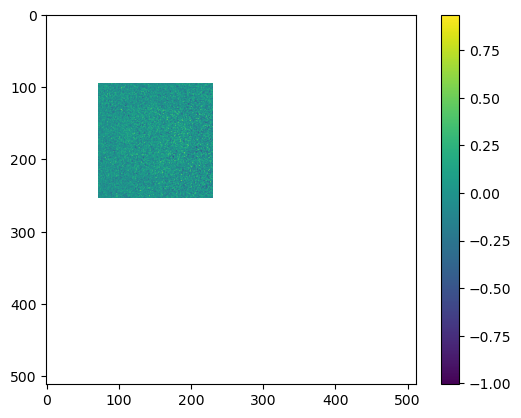

In [383]:
plt.imshow(images_grp["number_var"][0], cmap = "viridis")
plt.colorbar()

# center = (172, 152)
# h = 80
# w = 80

# plt.xlim(center[1] - w, center[1] + w)
# plt.ylim(center[0] + h, center[0] - h)

# plt.xlim(220, 240)
# plt.ylim(180, 150)

plt.show()

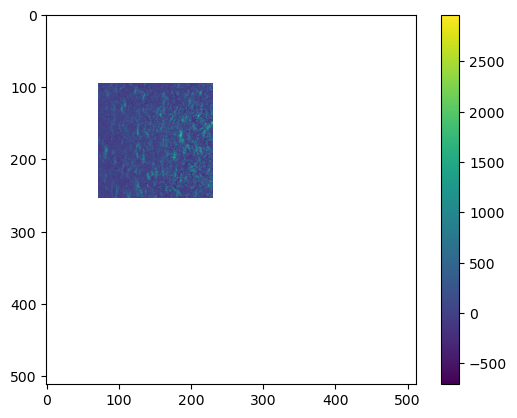

In [384]:
plt.imshow(images_grp["atoms_var"].iloc[0] - images_grp["atoms"].iloc[0], cmap = "viridis")
plt.colorbar()

# center = (172, 152)
# h = 80
# w = 80

# plt.xlim(center[1] - w, center[1] + w)
# plt.ylim(center[0] + h, center[0] - h)

# plt.xlim(220, 240)
# plt.ylim(180, 150)

plt.show()

In [385]:
def circ_ring(r, image_sizes, ring_position):
    '''
    This function creates an image (2D numpy array) of a ring with radius r
    Input:
        r: radius of the circle
        image_sizes: tuple (image_size_x, image_size_y) of image sizes in x/y direction
        ring_position: tuple (pos_x, pos_y), coordinates of the center of the ring (the point (0,0) is in the top left corner)
    Output:
        - ring mask (2D numpy array) with ones/True in the ring and zeros/False outside of the ring
    '''
    image_size_x, image_size_y = image_sizes
    pos_x, pos_y = ring_position

    x = np.arange(0, image_size_x)
    y = np.arange(0, image_size_y)

    r_x, r_y = np.meshgrid(x,y)

    # Mask 1 is the inverse of a circle with radius r
    # Mask 2 is a circle with radius r+1
    mask1 = (r_x-pos_x)**2 + (r_y-pos_y)**2 >= r**2
    mask2 = (r_x-pos_x)**2 + (r_y-pos_y)**2 < (r + 1)**2

    return mask2*mask1 # the overlap of the two masks is a ring

In [386]:
def radial_average(image, averaging_midpoint):
    '''
    This function takes an image (2D numpy array) and calculates its radial average (1D numpy array).
    For plotting one should use the return on the y-axis and radial_axis on the x-axis.
    This function does not control if a radius lies partially outside of the image
    Input:
        image:
        averaging_midpoint: tuple (midpoint_x, midpoint_y), that determines the central point of the radial average (the point (0,0) is in the top left corner)
    Output:
        radial_axis: x-axis to plot the radial_average using e.g. matplotlib.pyplot.plot()
        radial_average:
    '''

    image_sizes = (np.shape(image))[::-1]  # tuple (image_size_x, image_size_y)

    radial_axis = np.arange(0, image_sizes[0]//2)
    radial_sum = np.zeros(image_sizes[0]//2)
    radial_N = np.zeros(image_sizes[0]//2)

    for r in radial_axis:


        radial_sum[r] = np.sum(image * circ_ring(r, image_sizes, averaging_midpoint))  # summed signal at radius r
        radial_N[r] = np.sum(circ_ring(r, image_sizes, averaging_midpoint))   # Number of pixels at radius r

    radial_average = radial_sum/radial_N

    return radial_axis, radial_average

In [387]:
def circ_mask(r, image_sizes, circle_position):
    '''
    This function creates an image (2D numpy array) of a circle with radius r
    Input:
        r: radius of the circle
        image_sizes: tuple (image_size_x, image_size_y) of image_sizes in number of pixels
        circle_position: tuple (pos_x, pos_y)  of the center coordinate of the circle (the point (0,0) is in the top left corner )
    Output:
        - circular mask with ones/True in the circle and zeros/False outside of the circle
    '''
    image_size_x, image_size_y = image_sizes
    pos_x, pos_y = circle_position

    x = np.arange(0, image_size_x)
    y = np.arange(0, image_size_y)

    r_x, r_y = np.meshgrid(x,y)       # r_x, r_y assign to each pixel its x, y coordinate


    mask = (r_x - pos_x)**2 + (r_y - pos_y)**2 <= r**2    # the circle equation is used here

    return mask

In [392]:
number = []
number_var = []

for i in range(len(images_grp)):

    number.append(radial_average(images_grp["density"].iloc[i], (center[1], center[0])))
    number_var.append(radial_average(images_grp["number_var"].iloc[i], (center[1], center[0])))

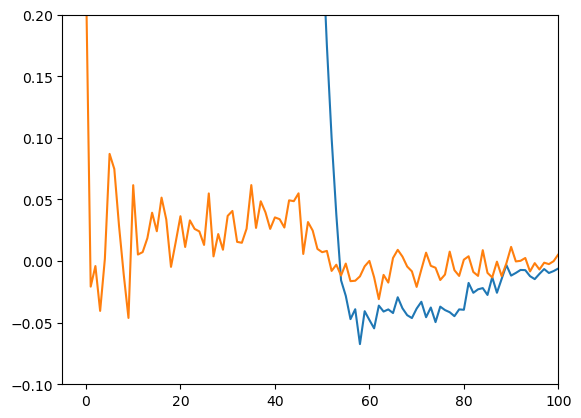

0.001
0.028545362015362515
-0.0009621215210669314


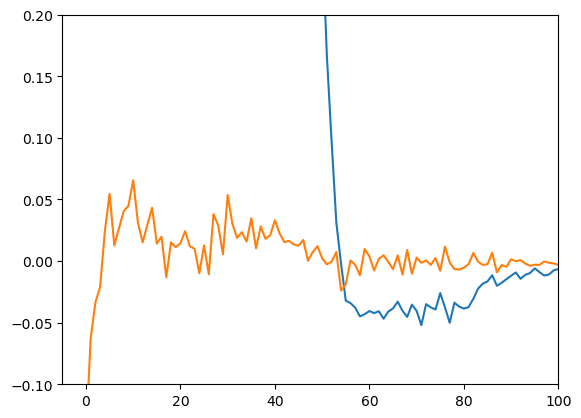

0.011
0.01899255145553851
-0.0003289160578060645


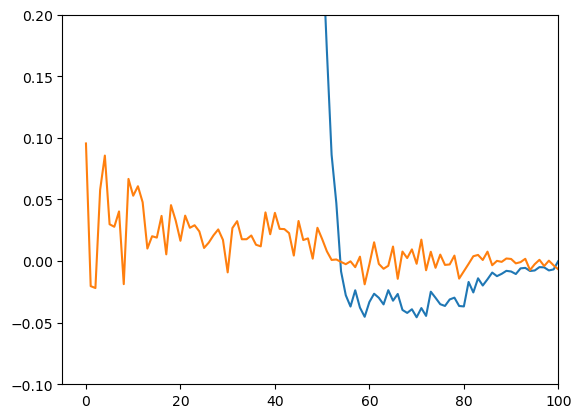

0.021
0.0207883796590334
1.2992769106881903e-05


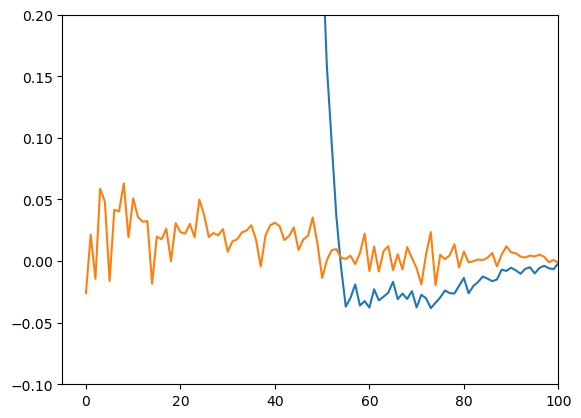

0.031
0.02264475206059128
0.0004945784960475153


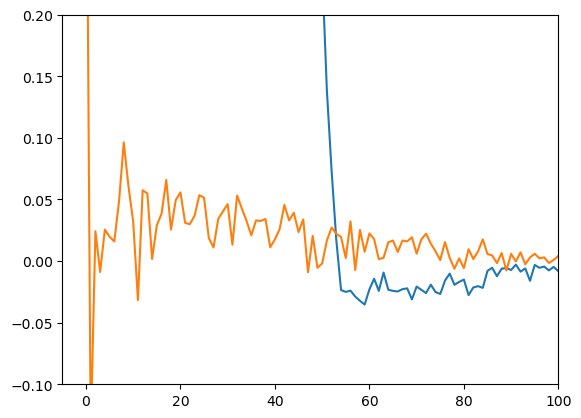

0.041
0.034135078220601495
0.0014718140373667459


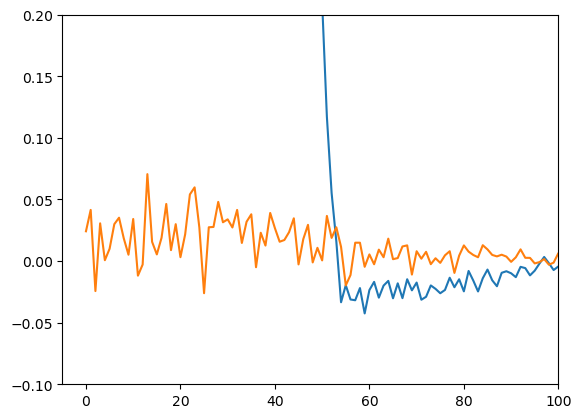

0.061
0.026586267650075983
0.0008109343071564686


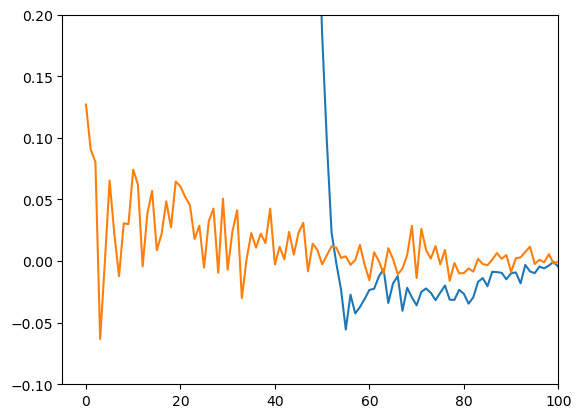

0.081
0.022927440175351674
0.000175718349400206


In [394]:
hold = []

for i in range(len(images_grp)):

    plt.plot(number[i][0], number[i][1])
    plt.plot(number_var[i][0], number_var[i][1])

    plt.xlim(-5, 100)
    plt.ylim(-0.1, 0.2)

    plt.show()

    hold.append(np.mean(number_var[i][1][20:40]))

    print(images_grp["Acc_hold_time"].iloc[i])
    print(np.mean(number_var[i][1][20:40]))
    print(np.mean(number_var[i][1][60:]))

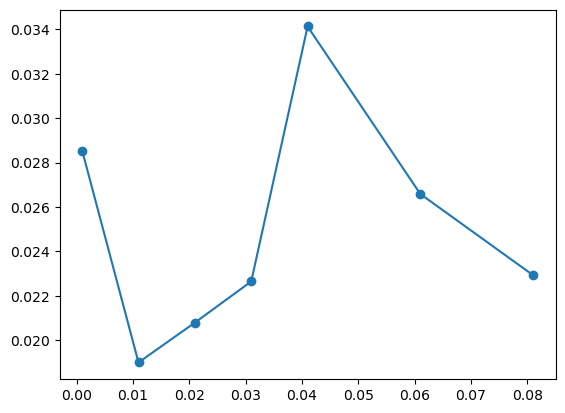

In [390]:
plt.plot(images_grp["Acc_hold_time"], hold)
plt.scatter(images_grp["Acc_hold_time"], hold)